**Prenosis Challenge**

I approached this problem by investigating two causal inference approaches to calculate a conditional average treatment effect (CATE) for each patient.  Each approach used a different backbone: causal forest and TARNet.  I then compared the results of each in several ways and made a decision whether to use a single model or an ensemble.

First we will create a basic causal forest model.

In [16]:
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# --- Step 1: Load and subset data ---
df = pd.read_csv("/content/Precision-Medicine-Challenge/data.csv")
df = df[df["D1"] == 1]  # focus on patients with condition D1

# --- Step 2: Define variables ---
Y = df["Y1"].values
T = df["W"].values
X = df[[f"X{i}" for i in range(1, 81)]].values

# --- Step 3: Fit causal forest model ---
est = CausalForestDML(
    model_t=LogisticRegression(max_iter=1000),
    model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
    discrete_treatment=True,
    n_estimators=500,
    random_state=42
)
est.fit(Y, T, X=X)

# --- Step 4: Estimate individual treatment effects (CATEs) ---
tau_hat = est.effect(X)  # estimated effect of treatment on Y1 for each patient

# --- Step 5: Recommend treatment ---
# Negative tau_hat means treatment reduces bad outcome probability
df["estimated_effect"] = tau_hat
recommend_treatment = df[df["estimated_effect"] < 0]

print("Recommend treatment for these patients:")
print(recommend_treatment[["patient_id", "estimated_effect"]].head())


Recommend treatment for these patients:
   patient_id  estimated_effect
3           4         -0.037627
5           6         -0.031388
6           7         -0.055848
8           9         -0.133121
9          10         -0.072680


Next we will create a TARNet model.

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Load and subset data ---
df = pd.read_csv("/content/Precision-Medicine-Challenge/data.csv")
df = df[df["D1"] == 1]  # Only patients with condition D1

Y = df["Y1"].values.astype(float)
W = df["W"].values.astype(float)
X = df[[f"X{i}" for i in range(1, 81)]].values

# --- Preprocess ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, W_train, W_val, Y_train, Y_val, idx_train, idx_val = train_test_split(
    X, W, Y, df.index, test_size=0.2, random_state=42
)

# --- Define TARNet architecture ---
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.y0_head = nn.Sequential(nn.Linear(hidden_dim, 1))
        self.y1_head = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, x, t):
        rep = self.shared(x)
        y0 = self.y0_head(rep)
        y1 = self.y1_head(rep)
        y_pred = t * y1 + (1 - t) * y0
        return y_pred, y0, y1

# --- Train the model ---
model = TARNet(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
W_tensor = torch.tensor(W_train, dtype=torch.float32).view(-1, 1)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

for epoch in range(200):
    optimizer.zero_grad()
    y_pred, _, _ = model(X_tensor, W_tensor)
    loss = loss_fn(y_pred, Y_tensor)
    loss.backward()
    optimizer.step()

# --- Estimate treatment effects (CATE) ---
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    _, y0_pred, y1_pred = model(X_val_tensor, torch.zeros_like(W_tensor[:len(X_val_tensor)]))
    cate_est = (y1_pred - y0_pred).numpy().flatten()

# --- Build result dataframe ---
results = pd.DataFrame({
    "patient_id": df.loc[idx_val, "patient_id"].values,
    "cate_estimate": cate_est
})
results["recommend_treatment"] = results["cate_estimate"] < 0

# --- Sort by strongest benefit (most negative effect) ---
results = results.sort_values(by="cate_estimate")

print("Top 10 patients most likely to benefit from treatment:")
print(results.head(10))



Top 10 patients most likely to benefit from treatment:
      patient_id  cate_estimate  recommend_treatment
1086         117      -1.545360                 True
216         4517      -1.235294                 True
110         6653      -1.108952                 True
530         2209      -1.092765                 True
788         2359      -1.040817                 True
1117        5923      -1.035205                 True
646         3899      -1.028533                 True
213         9897      -1.022305                 True
659         7694      -1.004539                 True
1065         544      -0.998038                 True


Next we can compare how the two models correlate.

Correlation between Causal Forest and TARNet CATEs: 0.237


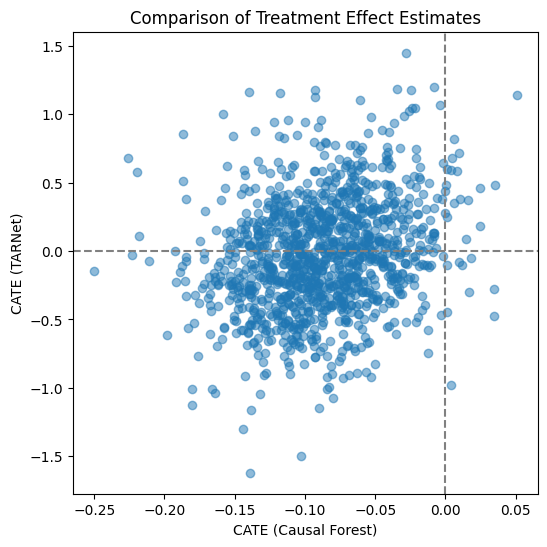


Patients both models recommend for treatment:
    patient_id  CATE_CausalForest  CATE_TARNet
0         4795          -0.110855    -0.900978
3         6886          -0.127550    -0.535607
4         4631          -0.122091    -0.164949
5         2522          -0.034918    -0.602397
6         1996          -0.065766    -0.192939
7          133          -0.095780    -0.642812
8         2022          -0.138471    -0.248944
13        3782          -0.022499    -0.249987
20        4545          -0.145784    -0.333327
21        3456          -0.111982    -0.509923


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# --- Load and subset data ---
df = pd.read_csv("/content/Precision-Medicine-Challenge/data.csv")
df = df[df["D1"] == 1]  # only patients with condition D1

Y = df["Y1"].values.astype(float)
W = df["W"].values.astype(float)
X = df[[f"X{i}" for i in range(1, 81)]].values

# --- Preprocess ---
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, W_train, W_val, Y_train, Y_val, idx_train, idx_val = train_test_split(
    X, W, Y, df.index, test_size=0.2, random_state=42
)

# =====================================================
# (1) Causal Forest (tree-based)
# =====================================================
cf = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    model_y=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    n_estimators=200,
    random_state=42,
)
cf.fit(Y_train, W_train, X=X_train)
cate_cf = cf.effect(X_val)

# =====================================================
# (2) TARNet (neural network–based)
# =====================================================
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.y0_head = nn.Linear(hidden_dim, 1)
        self.y1_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, t):
        rep = self.shared(x)
        y0 = self.y0_head(rep)
        y1 = self.y1_head(rep)
        y_pred = t * y1 + (1 - t) * y0
        return y_pred, y0, y1

# Train TARNet
model = TARNet(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
W_tensor = torch.tensor(W_train, dtype=torch.float32).view(-1, 1)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

for epoch in range(200):
    optimizer.zero_grad()
    y_pred, _, _ = model(X_tensor, W_tensor)
    loss = loss_fn(y_pred, Y_tensor)
    loss.backward()
    optimizer.step()

# TARNet CATE
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    _, y0_pred, y1_pred = model(X_val_tensor, torch.zeros_like(W_tensor[:len(X_val_tensor)]))
    cate_tarnet = (y1_pred - y0_pred).numpy().flatten()

# =====================================================
# (3) Combine and compare results
# =====================================================
results = pd.DataFrame({
    "patient_id": df.loc[idx_val, "patient_id"].values,
    "CATE_CausalForest": cate_cf,
    "CATE_TARNet": cate_tarnet
})

# correlation between methods
corr = np.corrcoef(results["CATE_CausalForest"], results["CATE_TARNet"])[0, 1]
print(f"Correlation between Causal Forest and TARNet CATEs: {corr:.3f}")

# --- Plot comparison ---
plt.figure(figsize=(6, 6))
plt.scatter(results["CATE_CausalForest"], results["CATE_TARNet"], alpha=0.5)
plt.xlabel("CATE (Causal Forest)")
plt.ylabel("CATE (TARNet)")
plt.title("Comparison of Treatment Effect Estimates")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

# --- Recommend based on both ---
results["Recommend_CF"] = results["CATE_CausalForest"] < 0
results["Recommend_TARNet"] = results["CATE_TARNet"] < 0

# Show patients where both agree on recommending treatment
agreement = results[results["Recommend_CF"] & results["Recommend_TARNet"]]
print("\nPatients both models recommend for treatment:")
print(agreement[["patient_id", "CATE_CausalForest", "CATE_TARNet"]].head(10))


The correlation is somewhat low, 0.237.  Perhaps we can create a CATE estimate using an ensemble of both models.

Top 10 patients recommended for treatment by ensemble:
     patient_id  CATE_CausalForest  CATE_TARNet  CATE_Ensemble  \
702        4832          -0.139311    -1.620263      -0.879787   
126         825          -0.103001    -1.497329      -0.800165   
525        2818          -0.144340    -1.303246      -0.723793   
856        7841          -0.180638    -1.126314      -0.653476   
982        2556          -0.138507    -1.163346      -0.650927   
294        9789          -0.089952    -1.149037      -0.619495   
603        6820          -0.164249    -1.037714      -0.600982   
417        1493          -0.180244    -1.011317      -0.595781   
250        7945          -0.166359    -1.009612      -0.587985   
764        9661          -0.131814    -1.042283      -0.587049   

     Recommend_Ensemble  
702                True  
126                True  
525                True  
856                True  
982                True  
294                True  
603                True  
417       

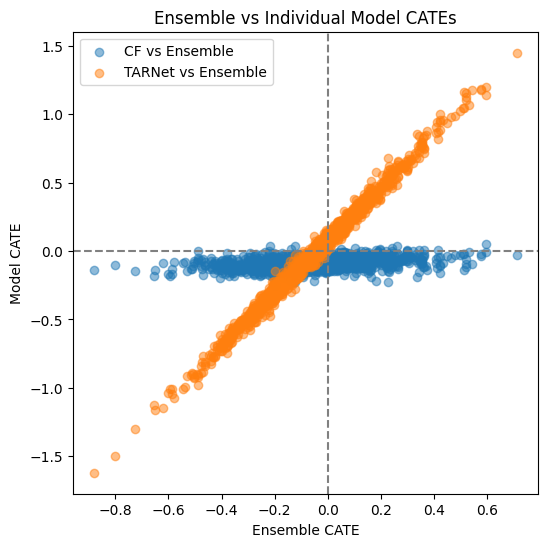

In [21]:
# --- Ensemble CATE estimate ---
results["CATE_Ensemble"] = results[["CATE_CausalForest", "CATE_TARNet"]].mean(axis=1)

# Recommend treatment if ensemble CATE < 0
results["Recommend_Ensemble"] = results["CATE_Ensemble"] < 0

# Sort patients by strongest expected benefit
results_sorted = results.sort_values(by="CATE_Ensemble")

print("Top 10 patients recommended for treatment by ensemble:")
print(results_sorted[["patient_id", "CATE_CausalForest", "CATE_TARNet", "CATE_Ensemble", "Recommend_Ensemble"]].head(10))

# Optional: visualize comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(results["CATE_Ensemble"], results["CATE_CausalForest"], alpha=0.5, label="CF vs Ensemble")
plt.scatter(results["CATE_Ensemble"], results["CATE_TARNet"], alpha=0.5, label="TARNet vs Ensemble")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("Ensemble CATE")
plt.ylabel("Model CATE")
plt.title("Ensemble vs Individual Model CATEs")
plt.legend()
plt.show()


Next we can refine that by creating a CATE estimate based on a weighted ensemble.

MSE TARNet: 0.201, MSE Causal Forest: 0.596
Weighted ensemble: TARNet weight=0.75, CF weight=0.25

Top 10 patients recommended for treatment by weighted ensemble:
     patient_id  CATE_CausalForest  CATE_TARNet  CATE_WeightedEnsemble  \
702        4832          -0.139311    -1.620263              -1.246754   
126         825          -0.103001    -1.497329              -1.145667   
525        2818          -0.144340    -1.303246              -1.010960   
982        2556          -0.138507    -1.163346              -0.904873   
856        7841          -0.180638    -1.126314              -0.887807   
294        9789          -0.089952    -1.149037              -0.881927   
946        3017          -0.079916    -1.074868              -0.823933   
603        6820          -0.164249    -1.037714              -0.817419   
764        9661          -0.131814    -1.042283              -0.812655   
417        1493          -0.180244    -1.011317              -0.801714   

     Recommend_Weighte

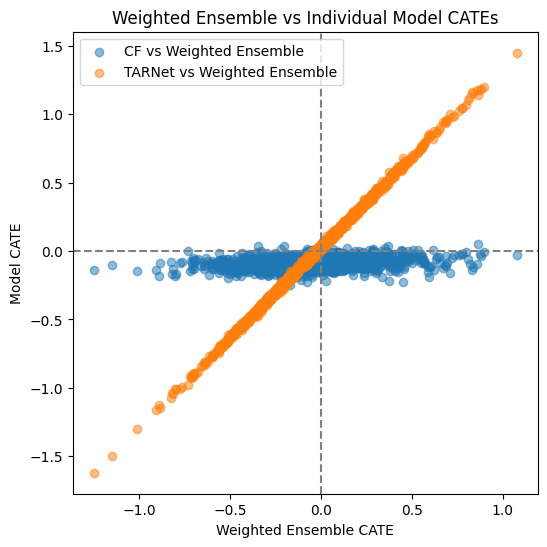

In [23]:
from sklearn.metrics import mean_squared_error

# --- Evaluate out-of-sample performance ---
# Predicted outcomes for the validation set
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).view(-1, 1)
W_val_tensor = torch.tensor(W_val, dtype=torch.float32).view(-1, 1)

# TARNet predictions
with torch.no_grad():
    y_pred_val, _, _ = model(torch.tensor(X_val, dtype=torch.float32), W_val_tensor)
    mse_tarnet = mean_squared_error(Y_val, y_pred_val.numpy().flatten())

# Causal Forest predictions
y_pred_cf = cf.effect(X_val)
mse_cf = mean_squared_error(Y_val, y_pred_cf)

print(f"MSE TARNet: {mse_tarnet:.3f}, MSE Causal Forest: {mse_cf:.3f}")

# --- Compute weights (inverse MSE) ---
weight_tarnet = 1 / mse_tarnet
weight_cf = 1 / mse_cf
total_weight = weight_tarnet + weight_cf
w_tarnet = weight_tarnet / total_weight
w_cf = weight_cf / total_weight

print(f"Weighted ensemble: TARNet weight={w_tarnet:.2f}, CF weight={w_cf:.2f}")

# --- Weighted ensemble CATE ---
results["CATE_WeightedEnsemble"] = w_tarnet * results["CATE_TARNet"] + w_cf * results["CATE_CausalForest"]
results["Recommend_WeightedEnsemble"] = results["CATE_WeightedEnsemble"] < 0

# Sort by strongest expected benefit
results_sorted = results.sort_values(by="CATE_WeightedEnsemble")

print("\nTop 10 patients recommended for treatment by weighted ensemble:")
print(results_sorted[["patient_id", "CATE_CausalForest", "CATE_TARNet", "CATE_WeightedEnsemble", "Recommend_WeightedEnsemble"]].head(10))

# Optional: visualize weighted ensemble vs individual models
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(results["CATE_WeightedEnsemble"], results["CATE_CausalForest"], alpha=0.5, label="CF vs Weighted Ensemble")
plt.scatter(results["CATE_WeightedEnsemble"], results["CATE_TARNet"], alpha=0.5, label="TARNet vs Weighted Ensemble")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("Weighted Ensemble CATE")
plt.ylabel("Model CATE")
plt.title("Weighted Ensemble vs Individual Model CATEs")
plt.legend()
plt.show()


Now we can do a comparison of both models  and an enemble of the two using proxy mean squared error (MSE) metrics.  We can then decide on which model to use based on that.

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML

# --- Load and subset data ---
df = pd.read_csv("/content/Precision-Medicine-Challenge/data.csv")
df = df[df["D1"] == 1]  # only patients with condition D1

Y = df["Y1"].values.astype(float)
W = df["W"].values.astype(float)
X = df[[f"X{i}" for i in range(1, 81)]].values

# --- Preprocess ---
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, W_train, W_val, Y_train, Y_val, idx_train, idx_val = train_test_split(
    X, W, Y, df.index, test_size=0.2, random_state=42
)

# =====================================================
# (1) Causal Forest
# =====================================================
cf = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    model_y=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    n_estimators=200,
    random_state=42,
)
cf.fit(Y_train, W_train, X=X_train)
cate_cf_val = cf.effect(X_val)  # CATE estimates

# Out-of-sample MSE proxy: use residuals of Y - W*predicted_effect
y_pred_cf_val = Y_val - W_val * cate_cf_val
mse_cf = mean_squared_error(Y_val, y_pred_cf_val)
print(f"Causal Forest MSE proxy: {mse_cf:.3f}")

# =====================================================
# (2) TARNet
# =====================================================
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.y0_head = nn.Linear(hidden_dim, 1)
        self.y1_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, t):
        rep = self.shared(x)
        y0 = self.y0_head(rep)
        y1 = self.y1_head(rep)
        y_pred = t * y1 + (1 - t) * y0
        return y_pred, y0, y1

# Train TARNet
model = TARNet(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
W_tensor = torch.tensor(W_train, dtype=torch.float32).view(-1, 1)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

for epoch in range(200):
    optimizer.zero_grad()
    y_pred, _, _ = model(X_tensor, W_tensor)
    loss = loss_fn(y_pred, Y_tensor)
    loss.backward()
    optimizer.step()

# TARNet CATE
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
W_val_tensor = torch.tensor(W_val, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    _, y0_pred, y1_pred = model(X_val_tensor, torch.zeros_like(W_val_tensor))
    cate_tarnet_val = (y1_pred - y0_pred).numpy().flatten()
    y_pred_tarnet_val = Y_val - W_val * cate_tarnet_val
    mse_tarnet = mean_squared_error(Y_val, y_pred_tarnet_val)

print(f"TARNet MSE proxy: {mse_tarnet:.3f}")

# =====================================================
# (3) Decide model or ensemble
# =====================================================
threshold_ratio = 0.05  # If MSEs are within 5%, ensemble
if abs(mse_cf - mse_tarnet) / max(mse_cf, mse_tarnet) <= threshold_ratio:
    # Similar performance -> weighted ensemble
    weight_cf = 1 / mse_cf
    weight_tarnet = 1 / mse_tarnet
    total_weight = weight_cf + weight_tarnet
    w_cf = weight_cf / total_weight
    w_tarnet = weight_tarnet / total_weight
    print(f"Using weighted ensemble: CF weight={w_cf:.2f}, TARNet weight={w_tarnet:.2f}")
    cate_final = w_cf * cate_cf_val + w_tarnet * cate_tarnet_val
    method_used = "Weighted Ensemble"
else:
    # Pick the better performing model
    if mse_cf < mse_tarnet:
        cate_final = cate_cf_val
        method_used = "Causal Forest"
    else:
        cate_final = cate_tarnet_val
        method_used = "TARNet"
    print(f"Using single model: {method_used}")

# =====================================================
# (4) Build results dataframe
# =====================================================
results = pd.DataFrame({
    "patient_id": df.loc[idx_val, "patient_id"].values,
    "CATE_Final": cate_final
})
results["Recommend_Treatment"] = results["CATE_Final"] < 0
results_sorted = results.sort_values(by="CATE_Final")

print(f"\nTop 10 patients recommended by {method_used}:")
print(results_sorted.head(10))

Causal Forest MSE proxy: 0.005
TARNet MSE proxy: 0.076
Using single model: Causal Forest

Top 10 patients recommended by Causal Forest:
      patient_id  CATE_Final  Recommend_Treatment
1139        1919   -0.238982                 True
765         5647   -0.223202                 True
216         4517   -0.220724                 True
143         3028   -0.213755                 True
121         6554   -0.206620                 True
416         3344   -0.199708                 True
32          5736   -0.194885                 True
50          2809   -0.193209                 True
417         1493   -0.186929                 True
797         6041   -0.185935                 True


The criteria above indicate that a single causal forest model is the best approach for this problem.  Furthermore, this is a relatively simple dataset.  There are only 10,000 rows in the dataset and of these, only 6,020 are relevant to our problem (i.e. D1=1).  There are 80 features used for inference.  This is a relatively small amount of data and small number of features that may not justify the complexity of TARNet.  The simplicity of the requirements and the proxy MSE scores indicate that we should select the simpler model.

Finally, we will go ahead and save the recommendations to a csv.

In [36]:
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# --- Load data ---
df = pd.read_csv("/content/Precision-Medicine-Challenge/data.csv")

# --- Subset patients with condition D1 (if needed) ---
df_d1 = df[df["D1"] == 1].copy()

# --- Prepare features and outcomes ---
Y = df_d1["Y1"].values.astype(float)
W = df_d1["W"].values.astype(float)
X = df_d1[[f"X{i}" for i in range(1, 81)]].values

# --- Standardize features (optional but recommended) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Fit Causal Forest ---
cf = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    model_y=RandomForestRegressor(n_estimators=50, min_samples_leaf=10),
    n_estimators=200,
    random_state=42
)
cf.fit(Y, W, X=X_scaled)

# --- Generate CATE estimates ---
cate_estimates = cf.effect(X_scaled)

# --- Create recommendation column (1=yes, 0=no) ---
# Assuming negative CATE means treatment reduces risk
df_d1["Recommend_Treatment"] = (cate_estimates < 0).astype(int)

# --- Merge back with full dataset if needed ---
df_final = df.copy()
df_final = df_final.merge(
    df_d1[["patient_id", "Recommend_Treatment"]],
    on="patient_id",
    how="left"
)
df_final["Recommend_Treatment"].fillna(0, inplace=True)  # patients without D1 get 0

# --- Save revised CSV ---
df_final.to_csv("data_with_recommendation.csv", index=False)

print("Saved revised CSV: data_with_recommendation.csv")


/tmp/ipython-input-1858790065.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["Recommend_Treatment"].fillna(0, inplace=True)  # patients without D1 get 0


Saved revised CSV: data_with_recommendation.csv
